In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.11


In [12]:
adata1= sc.read_10x_mtx("filtered_gene_bc_matrices/NML1Lin", 
                       var_names= "gene_symbols", cache= True)

... reading from cache file cache\filtered_gene_bc_matrices-NML1Lin-matrix.h5ad


In [13]:
adata2= sc.read_10x_mtx("filtered_gene_bc_matrices/NML2Lin/", 
                       var_names= "gene_symbols", cache= True)

... reading from cache file cache\filtered_gene_bc_matrices-NML2Lin-matrix.h5ad


In [14]:
adata3= sc.read_10x_mtx("filtered_gene_bc_matrices/NML3Lin/", 
                       var_names= "gene_symbols", cache= True)

... reading from cache file cache\filtered_gene_bc_matrices-NML3Lin-matrix.h5ad


In [15]:
adata4= sc.read_10x_mtx("filtered_gene_bc_matrices/IPF1Lin/", 
                       var_names= "gene_symbols", cache= True)

... reading from cache file cache\filtered_gene_bc_matrices-IPF1Lin-matrix.h5ad


In [17]:
adata5= sc.read_10x_mtx("filtered_gene_bc_matrices/IPF2Lin/", 
                       var_names= "gene_symbols", cache= True) 

... reading from cache file cache\filtered_gene_bc_matrices-IPF2Lin-matrix.h5ad


In [18]:
adata6= sc.read_10x_mtx("filtered_gene_bc_matrices/IPF3Lin/", 
                       var_names= "gene_symbols", cache= True) 

... writing an h5ad cache file to speedup reading next time


In [20]:
adata= adata1.concatenate([adata2, adata3, adata4, adata5, adata6], batch_categories= ['CON_1','CON_2', 'CON_3','IPF_1', 'IPF_2', 'IPF_3'])

In [21]:
adata

AnnData object with n_obs × n_vars = 35331 × 33694
    obs: 'batch'
    var: 'gene_ids'

In [22]:
adata.obs

batch
AAACCTGAGTGTTGAA-1-CON_1  CON_1
AAACCTGCAGCCACCA-1-CON_1  CON_1
AAACCTGCATACGCCG-1-CON_1  CON_1
AAACCTGCATTTCACT-1-CON_1  CON_1
AAACCTGGTGTAACGG-1-CON_1  CON_1
...                         ...
TTTGTCATCGCCTGTT-1-IPF_3  IPF_3
TTTGTCATCGGAAACG-1-IPF_3  IPF_3
TTTGTCATCGGCTACG-1-IPF_3  IPF_3
TTTGTCATCGTCCGTT-1-IPF_3  IPF_3
TTTGTCATCTTTAGGG-1-IPF_3  IPF_3

[35331 rows x 1 columns]

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells= 3)

filtered out 40 cells that have less than 200 genes expressed
filtered out 11501 genes that are detected in less than 3 cells


In [24]:
adata.var['mt']= adata.var_names.str.startswith('MT-') # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt"], percent_top= None, log1p= False, inplace= True)

In [25]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGTGTTGAA-1-CON_1  CON_1      940                939        2253.0   
AAACCTGCAGCCACCA-1-CON_1  CON_1     2186               2186        9481.0   
AAACCTGCATACGCCG-1-CON_1  CON_1     1321               1321        2838.0   
AAACCTGCATTTCACT-1-CON_1  CON_1     1935               1934        5111.0   
AAACCTGGTGTAACGG-1-CON_1  CON_1     1605               1605        7035.0   
...                         ...      ...                ...           ...   
TTTGTCATCGCCTGTT-1-IPF_3  IPF_3      565                565        1226.0   
TTTGTCATCGGAAACG-1-IPF_3  IPF_3      574                574        1219.0   
TTTGTCATCGGCTACG-1-IPF_3  IPF_3      813                813        1619.0   
TTTGTCATCGTCCGTT-1-IPF_3  IPF_3     1635               1634        4509.0   
TTTGTCATCTTTAGGG-1-IPF_3  IPF_3     2049               2049        6301.0   

                          total_counts_mt  pct_counts_mt  
AAACCTGAGTGTTGAA-1-CON_1             69.0       3.062583  
AAACCTGCAGCCACCA-1-CON_1            189.0       1.993461  
AAACCTGCATACGCCG-1-CON_1             23.0       0.810430  
AAACCTGCATTTCACT-1-CON_1            190.0       3.717472  
AAACCTGGTGTAACGG-1-CON_1            267.0       3.795309  
...                                   ...            ...  
TTTGTCATCGCCTGTT-1-IPF_3             12.0       0.978793  
TTTGTCATCGGAAACG-1-IPF_3             62.0       5.086136  
TTTGTCATCGGCTACG-1-IPF_3             69.0       4.261890  
TTTGTCATCGTCCGTT-1-IPF_3            182.0       4.036372  
TTTGTCATCTTTAGGG-1-IPF_3            213.0       3.380416  

[35291 rows x 6 columns]

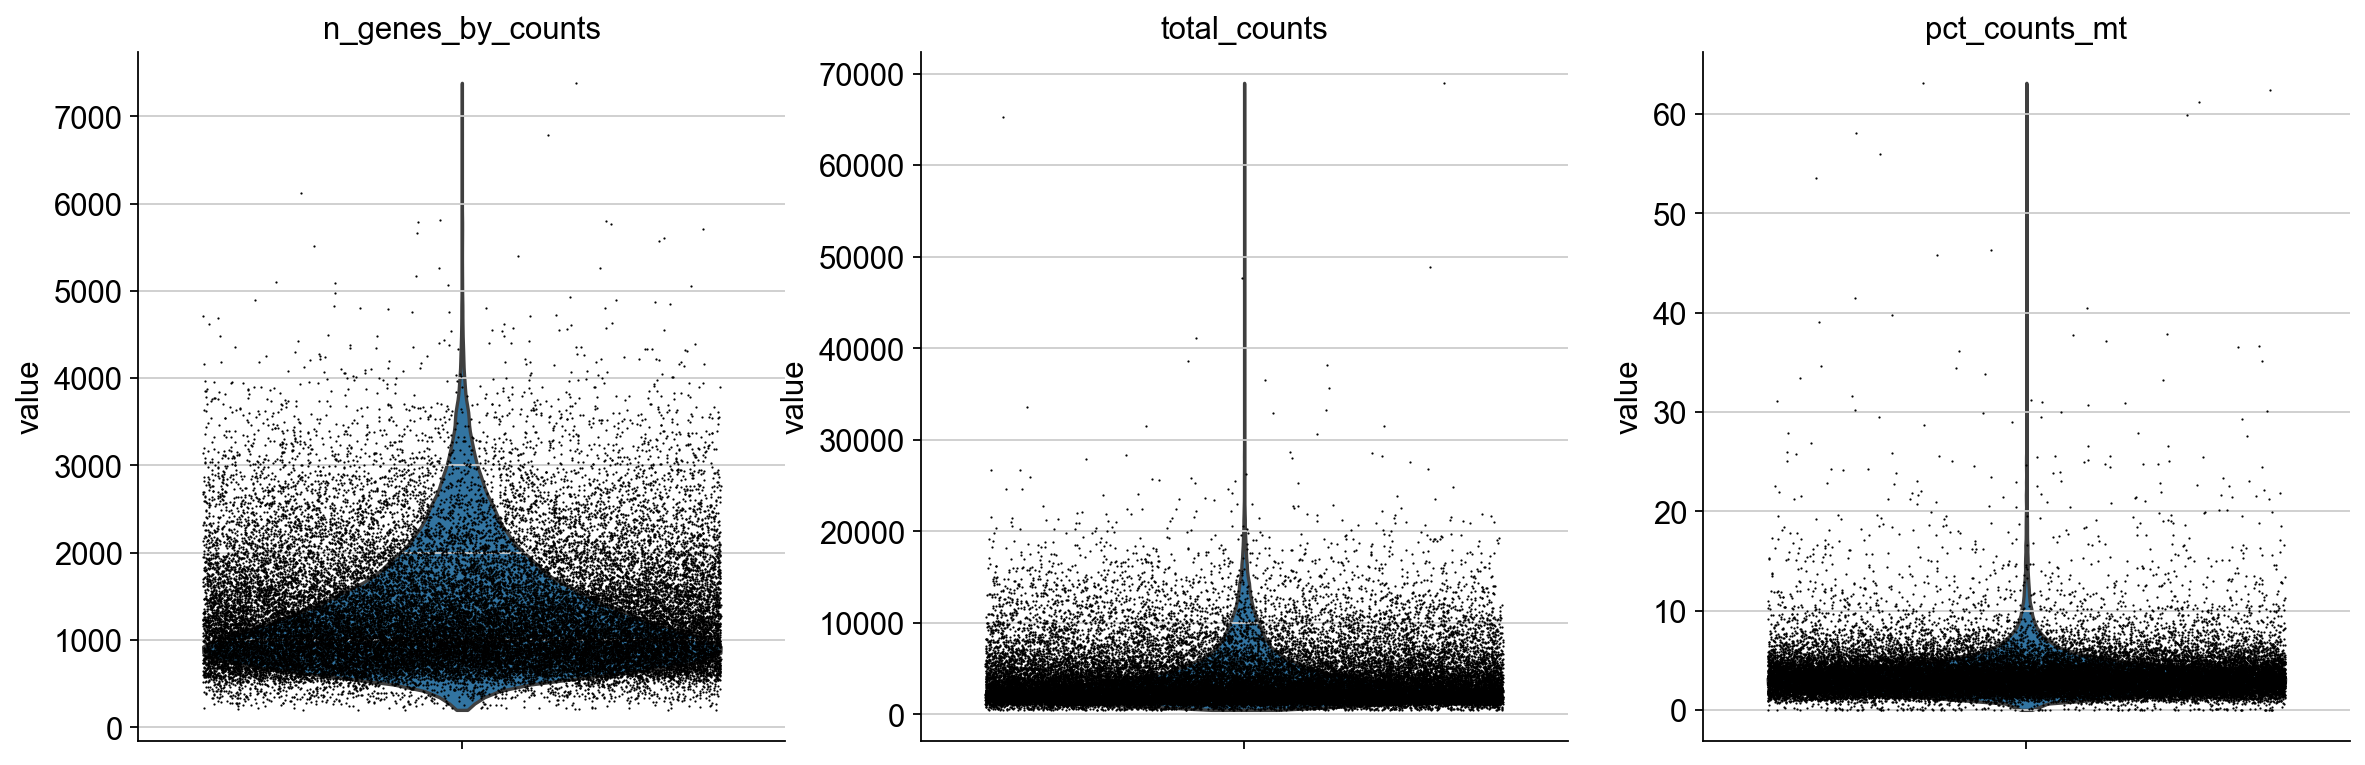

In [26]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel= True)

In [27]:
adata= adata[adata.obs.n_genes_by_counts <4000, :]
adata= adata[adata.obs.total_counts <17500, :]
adata= adata[adata.obs.pct_counts_mt <10, :]

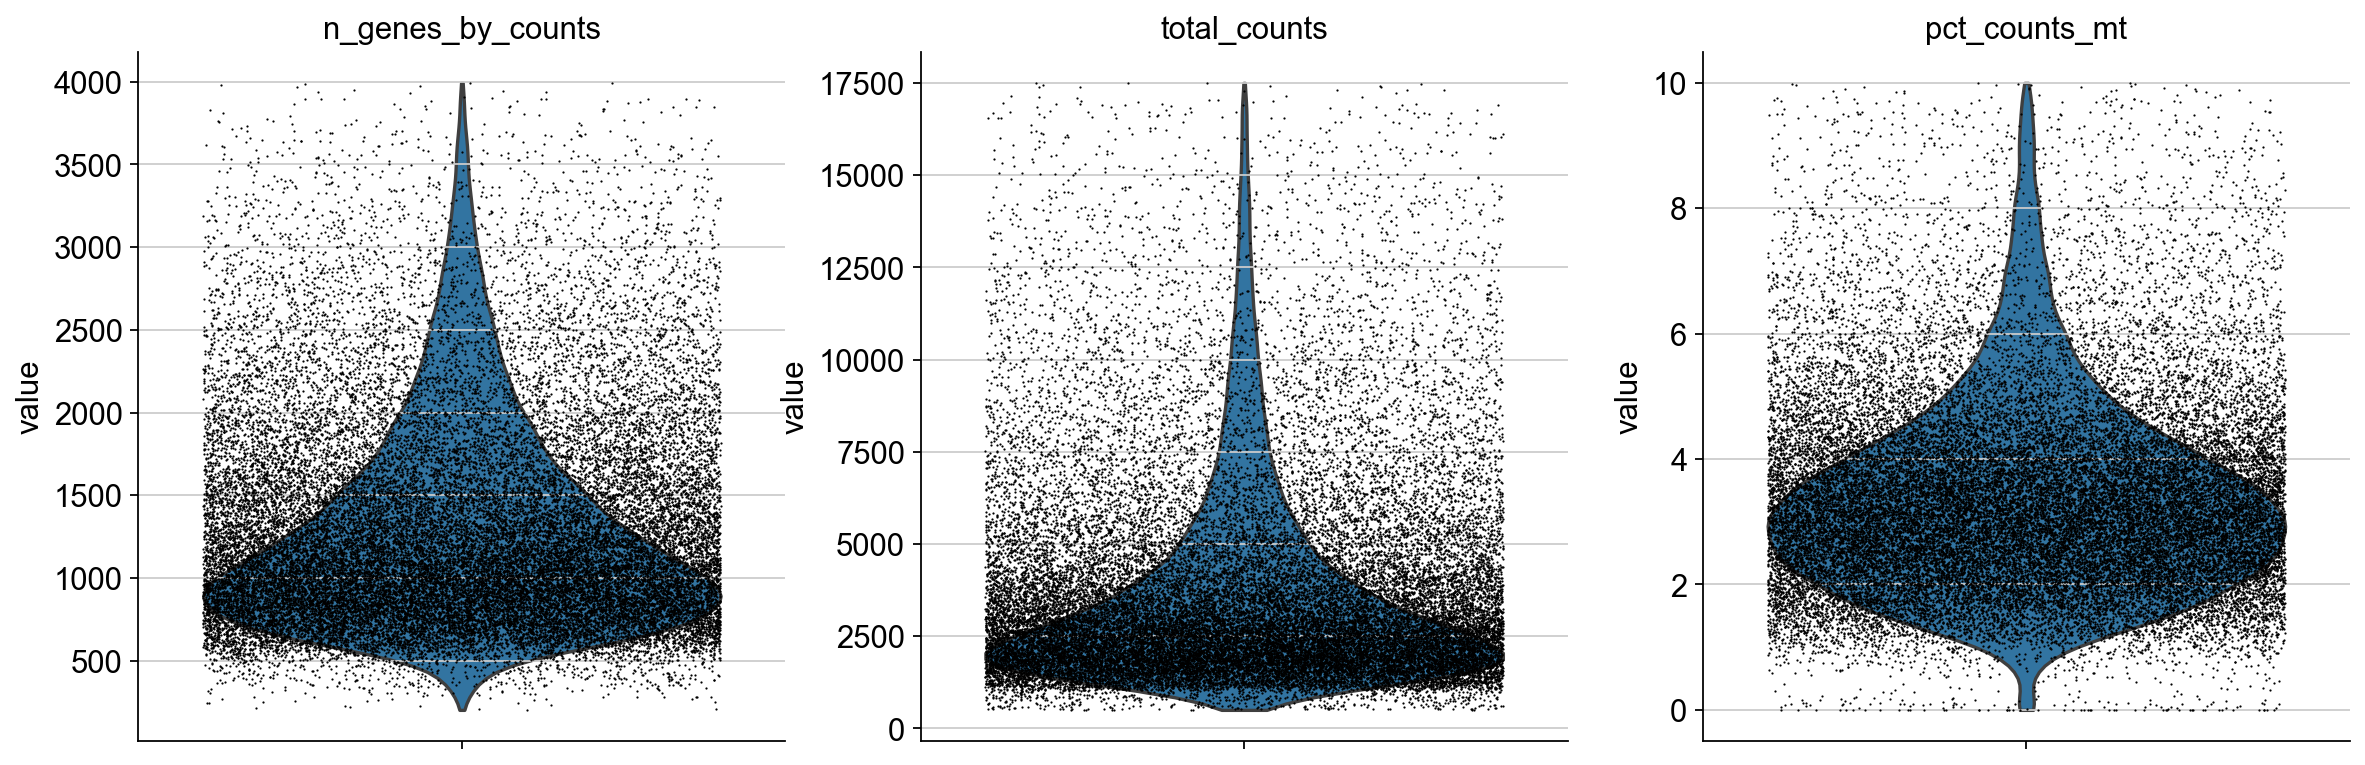

In [28]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel= True)

In [29]:
adata

View of AnnData object with n_obs × n_vars = 34312 × 22193
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [30]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [31]:
sc.pp.log1p(adata)

In [32]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean= 3, min_disp= 0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [33]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [34]:
sc.tl.pca(adata, svd_solver= 'arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


In [37]:
# Scanpy Integration 
import bbknn

In [38]:
sc.external.pp.bbknn(adata, batch_key="batch")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [39]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


In [40]:
sc.tl.leiden(adata, resolution= 0.25)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


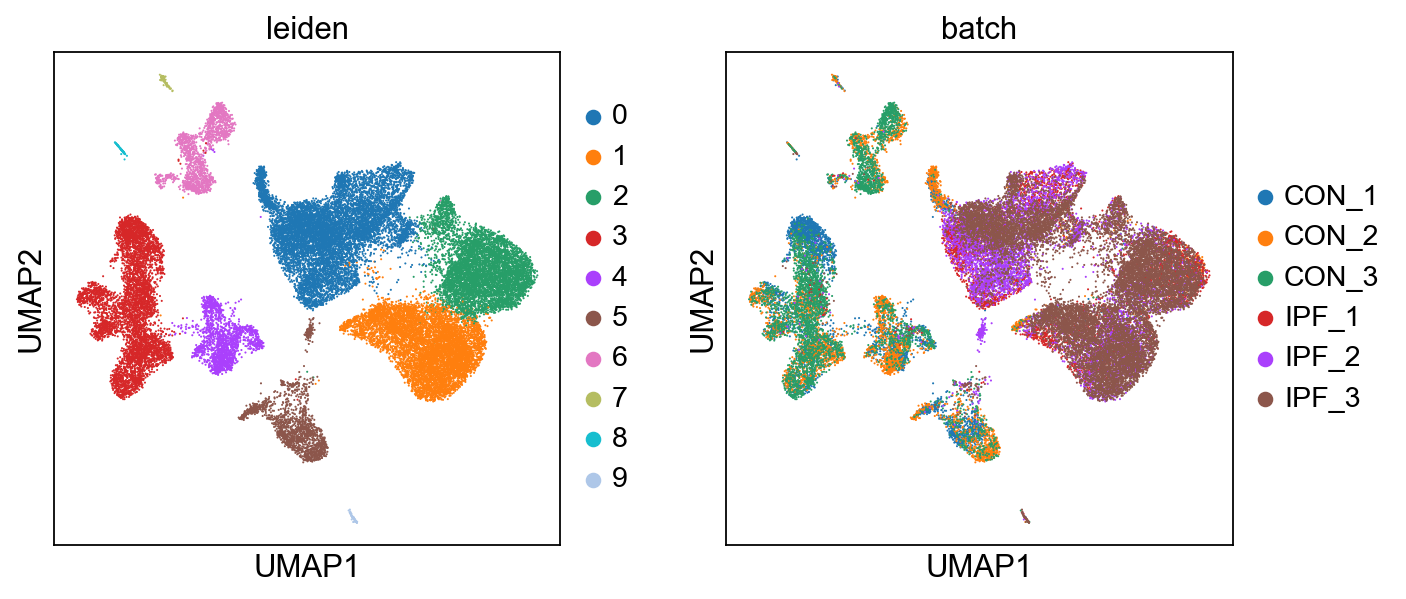

In [41]:
sc.pl.umap(adata, color=["leiden", "batch"])

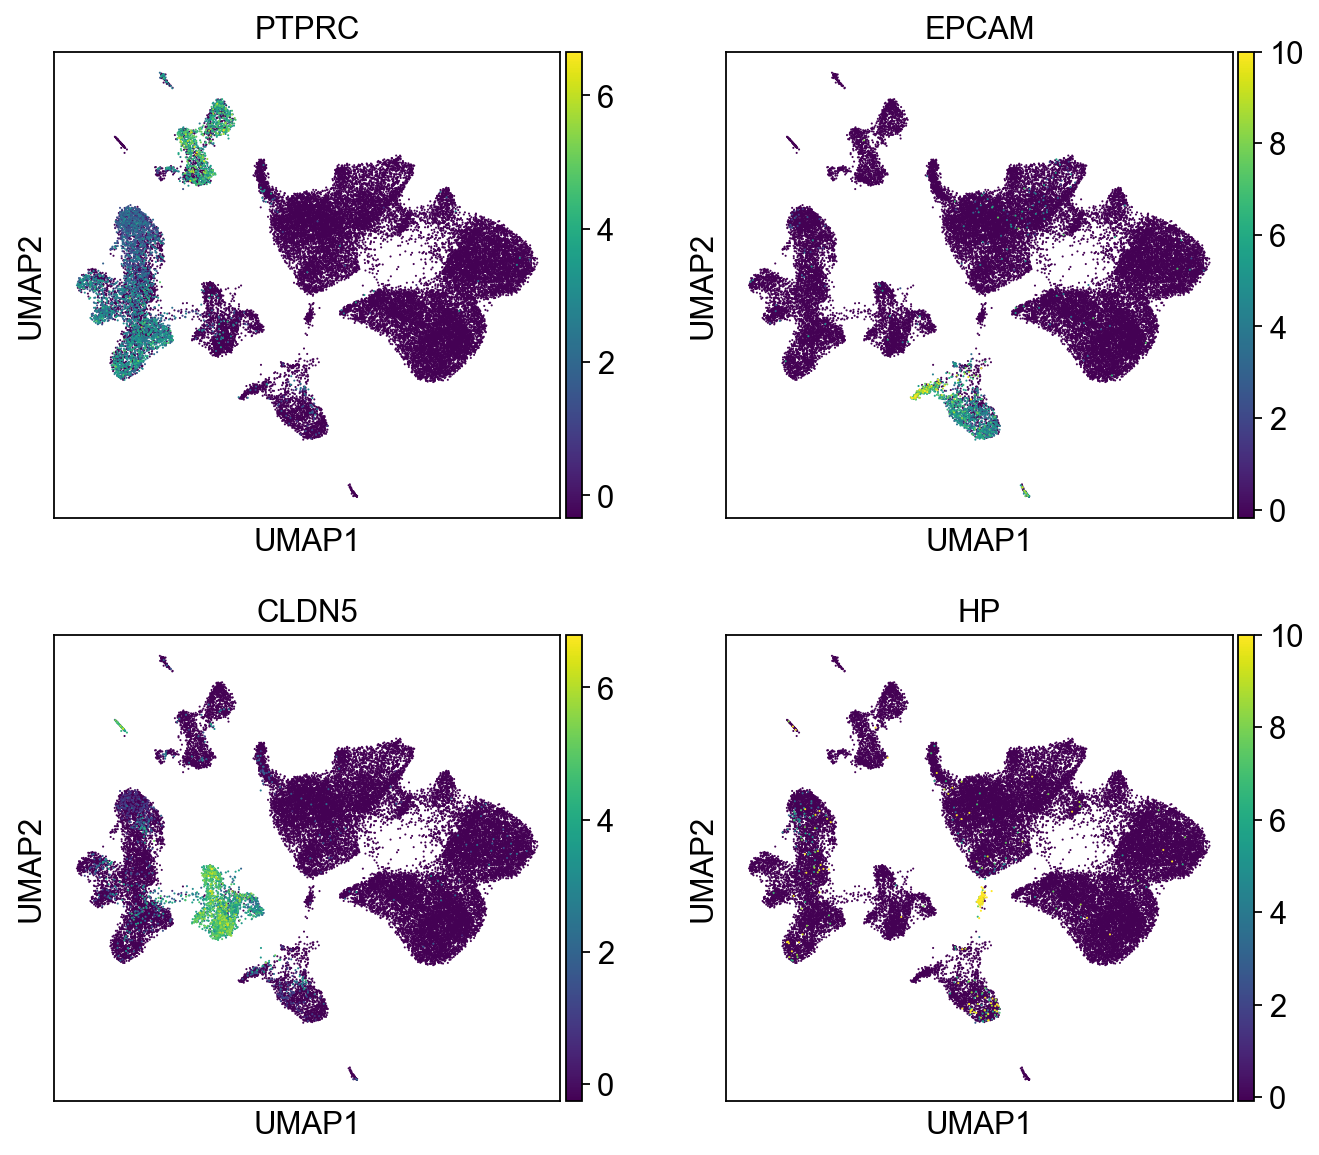

In [42]:
sc.pl.umap(adata, color=['PTPRC', "EPCAM", "CLDN5", "HP"], ncols= 2)

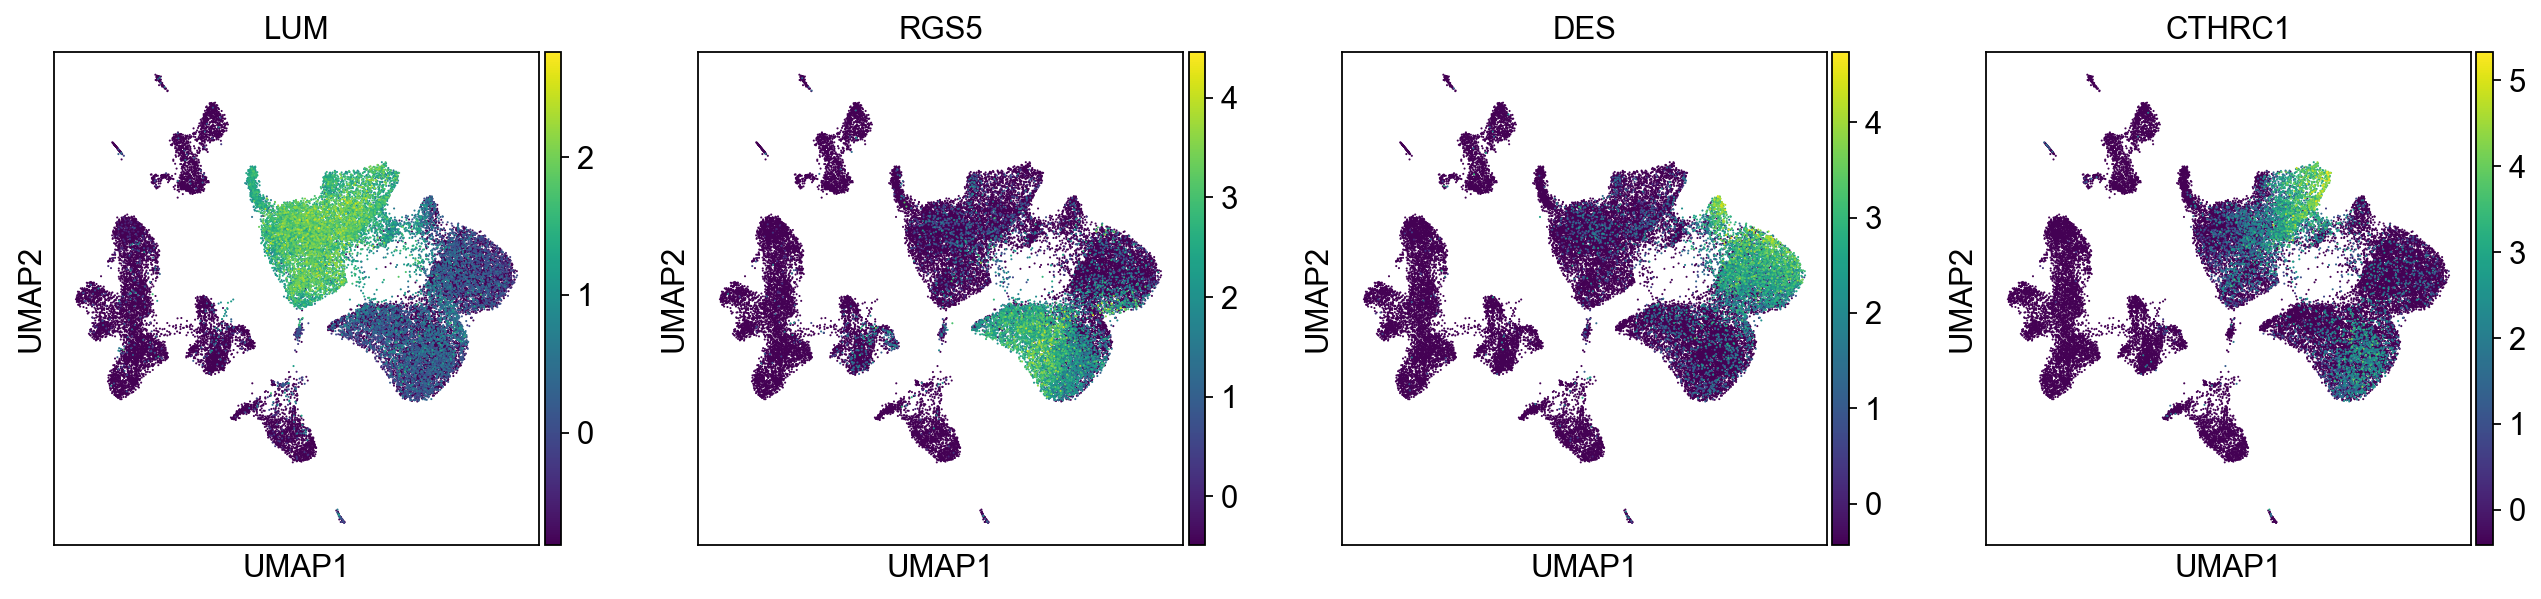

In [43]:
sc.pl.umap(adata, color=['LUM', "RGS5", "DES", "CTHRC1"])

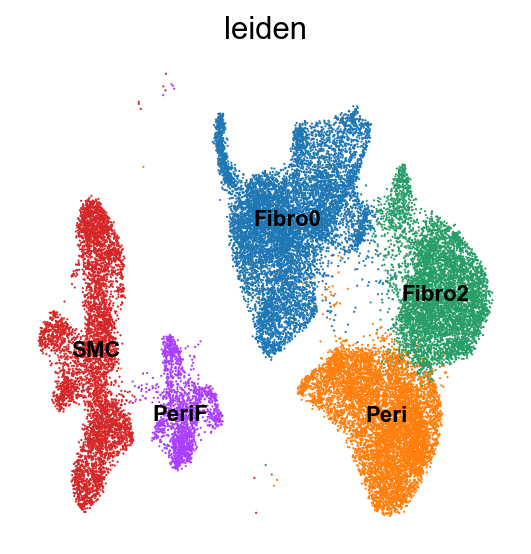

In [67]:
sc.pl.umap(adata, color= 'leiden', legend_loc= 'on data', legend_fontsize= 10, frameon= False)

In [45]:
MESEN= ['0', '1', '2', '3', '4']
adata= adata[adata.obs.leiden.isin(MESEN)]

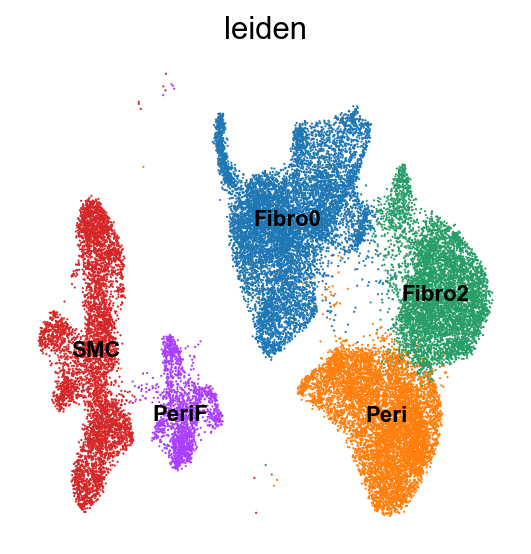

In [66]:
sc.pl.umap(adata, color= 'leiden', legend_loc= 'on data', legend_fontsize= 10, frameon= False)

In [51]:
new_cluster_names= ['Fibro0', 'Peri', 'Fibro2', 'SMC', 'PeriF']
adata.rename_categories('leiden', new_cluster_names)

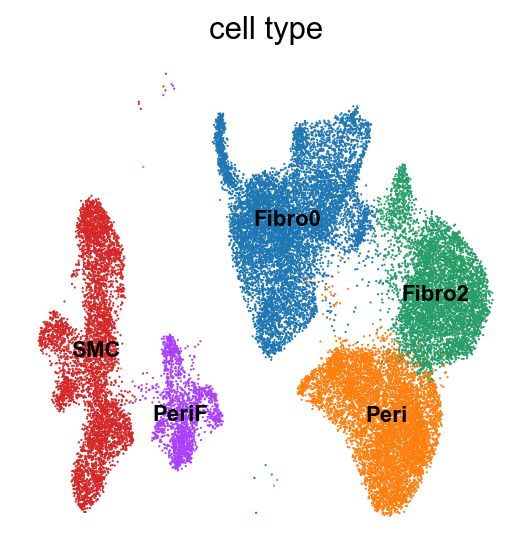

In [65]:
sc.pl.umap(adata, color= 'leiden', legend_loc= 'on data', legend_fontsize= 10, title= "cell type", frameon= False)

In [53]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGTGTTGAA-1-CON_1  CON_1      940                939        2253.0   
AAACCTGCAGCCACCA-1-CON_1  CON_1     2186               2186        9481.0   
AAACCTGCATACGCCG-1-CON_1  CON_1     1321               1321        2838.0   
AAACGGGAGTCCATAC-1-CON_1  CON_1     2896               2896       13451.0   
AAACGGGCACCAGTTA-1-CON_1  CON_1     1411               1411        3159.0   
...                         ...      ...                ...           ...   
TTTGTCATCGCCTGTT-1-IPF_3  IPF_3      565                565        1226.0   
TTTGTCATCGGAAACG-1-IPF_3  IPF_3      574                574        1219.0   
TTTGTCATCGGCTACG-1-IPF_3  IPF_3      813                813        1619.0   
TTTGTCATCGTCCGTT-1-IPF_3  IPF_3     1635               1634        4509.0   
TTTGTCATCTTTAGGG-1-IPF_3  IPF_3     2049               2049        6301.0   

                          total_counts_mt  pct_counts_mt  leiden  
AAACCTGAGTGTTGAA-1-CON_1             69.0       3.062583  Fibro0  
AAACCTGCAGCCACCA-1-CON_1            189.0       1.993461     SMC  
AAACCTGCATACGCCG-1-CON_1             23.0       0.810430   PeriF  
AAACGGGAGTCCATAC-1-CON_1            587.0       4.363988     SMC  
AAACGGGCACCAGTTA-1-CON_1             46.0       1.456157   PeriF  
...                                   ...            ...     ...  
TTTGTCATCGCCTGTT-1-IPF_3             12.0       0.978793    Peri  
TTTGTCATCGGAAACG-1-IPF_3             62.0       5.086136    Peri  
TTTGTCATCGGCTACG-1-IPF_3             69.0       4.261890  Fibro2  
TTTGTCATCGTCCGTT-1-IPF_3            182.0       4.036372  Fibro0  
TTTGTCATCTTTAGGG-1-IPF_3            213.0       3.380416    Peri  

[30651 rows x 7 columns]

In [54]:
batch= adata.obs['batch']
batch

AAACCTGAGTGTTGAA-1-CON_1    CON_1
AAACCTGCAGCCACCA-1-CON_1    CON_1
AAACCTGCATACGCCG-1-CON_1    CON_1
AAACGGGAGTCCATAC-1-CON_1    CON_1
AAACGGGCACCAGTTA-1-CON_1    CON_1
                            ...  
TTTGTCATCGCCTGTT-1-IPF_3    IPF_3
TTTGTCATCGGAAACG-1-IPF_3    IPF_3
TTTGTCATCGGCTACG-1-IPF_3    IPF_3
TTTGTCATCGTCCGTT-1-IPF_3    IPF_3
TTTGTCATCTTTAGGG-1-IPF_3    IPF_3
Name: batch, Length: 30651, dtype: category
Categories (6, object): ['CON_1', 'CON_2', 'CON_3', 'IPF_1', 'IPF_2', 'IPF_3']

In [57]:
# Remove suffixes '1', '2', '3'
batch = batch.str.replace('1$', '', regex=True)
batch = batch.str.replace('2$', '', regex=True)
batch = batch.str.replace('3$', '', regex=True)

print(batch)

AAACCTGAGTGTTGAA-1-CON_1    CON_
AAACCTGCAGCCACCA-1-CON_1    CON_
AAACCTGCATACGCCG-1-CON_1    CON_
AAACGGGAGTCCATAC-1-CON_1    CON_
AAACGGGCACCAGTTA-1-CON_1    CON_
                            ... 
TTTGTCATCGCCTGTT-1-IPF_3    IPF_
TTTGTCATCGGAAACG-1-IPF_3    IPF_
TTTGTCATCGGCTACG-1-IPF_3    IPF_
TTTGTCATCGTCCGTT-1-IPF_3    IPF_
TTTGTCATCTTTAGGG-1-IPF_3    IPF_
Name: batch, Length: 30651, dtype: object


In [58]:
leiden= adata.obs['leiden']
leiden

AAACCTGAGTGTTGAA-1-CON_1    Fibro0
AAACCTGCAGCCACCA-1-CON_1       SMC
AAACCTGCATACGCCG-1-CON_1     PeriF
AAACGGGAGTCCATAC-1-CON_1       SMC
AAACGGGCACCAGTTA-1-CON_1     PeriF
                             ...  
TTTGTCATCGCCTGTT-1-IPF_3      Peri
TTTGTCATCGGAAACG-1-IPF_3      Peri
TTTGTCATCGGCTACG-1-IPF_3    Fibro2
TTTGTCATCGTCCGTT-1-IPF_3    Fibro0
TTTGTCATCTTTAGGG-1-IPF_3      Peri
Name: leiden, Length: 30651, dtype: category
Categories (5, object): ['Fibro0', 'Peri', 'Fibro2', 'SMC', 'PeriF']

In [60]:
CONIPF= batch.str.cat(leiden)
CONIPF

AAACCTGAGTGTTGAA-1-CON_1    CON_Fibro0
AAACCTGCAGCCACCA-1-CON_1       CON_SMC
AAACCTGCATACGCCG-1-CON_1     CON_PeriF
AAACGGGAGTCCATAC-1-CON_1       CON_SMC
AAACGGGCACCAGTTA-1-CON_1     CON_PeriF
                               ...    
TTTGTCATCGCCTGTT-1-IPF_3      IPF_Peri
TTTGTCATCGGAAACG-1-IPF_3      IPF_Peri
TTTGTCATCGGCTACG-1-IPF_3    IPF_Fibro2
TTTGTCATCGTCCGTT-1-IPF_3    IPF_Fibro0
TTTGTCATCTTTAGGG-1-IPF_3      IPF_Peri
Name: batch, Length: 30651, dtype: object

In [61]:
adata.obs['CONIPF_clusters']= CONIPF

In [62]:
adata.obs

batch  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGTGTTGAA-1-CON_1  CON_1      940                939        2253.0   
AAACCTGCAGCCACCA-1-CON_1  CON_1     2186               2186        9481.0   
AAACCTGCATACGCCG-1-CON_1  CON_1     1321               1321        2838.0   
AAACGGGAGTCCATAC-1-CON_1  CON_1     2896               2896       13451.0   
AAACGGGCACCAGTTA-1-CON_1  CON_1     1411               1411        3159.0   
...                         ...      ...                ...           ...   
TTTGTCATCGCCTGTT-1-IPF_3  IPF_3      565                565        1226.0   
TTTGTCATCGGAAACG-1-IPF_3  IPF_3      574                574        1219.0   
TTTGTCATCGGCTACG-1-IPF_3  IPF_3      813                813        1619.0   
TTTGTCATCGTCCGTT-1-IPF_3  IPF_3     1635               1634        4509.0   
TTTGTCATCTTTAGGG-1-IPF_3  IPF_3     2049               2049        6301.0   

                          total_counts_mt  pct_counts_mt  leiden  \
AAACCTGAGTGTTGAA-1-CON_1             69.0       3.062583  Fibro0   
AAACCTGCAGCCACCA-1-CON_1            189.0       1.993461     SMC   
AAACCTGCATACGCCG-1-CON_1             23.0       0.810430   PeriF   
AAACGGGAGTCCATAC-1-CON_1            587.0       4.363988     SMC   
AAACGGGCACCAGTTA-1-CON_1             46.0       1.456157   PeriF   
...                                   ...            ...     ...   
TTTGTCATCGCCTGTT-1-IPF_3             12.0       0.978793    Peri   
TTTGTCATCGGAAACG-1-IPF_3             62.0       5.086136    Peri   
TTTGTCATCGGCTACG-1-IPF_3             69.0       4.261890  Fibro2   
TTTGTCATCGTCCGTT-1-IPF_3            182.0       4.036372  Fibro0   
TTTGTCATCTTTAGGG-1-IPF_3            213.0       3.380416    Peri   

                         CONIPF_clusters  
AAACCTGAGTGTTGAA-1-CON_1      CON_Fibro0  
AAACCTGCAGCCACCA-1-CON_1         CON_SMC  
AAACCTGCATACGCCG-1-CON_1       CON_PeriF  
AAACGGGAGTCCATAC-1-CON_1         CON_SMC  
AAACGGGCACCAGTTA-1-CON_1       CON_PeriF  
...                                  ...  
TTTGTCATCGCCTGTT-1-IPF_3        IPF_Peri  
TTTGTCATCGGAAACG-1-IPF_3        IPF_Peri  
TTTGTCATCGGCTACG-1-IPF_3      IPF_Fibro2  
TTTGTCATCGTCCGTT-1-IPF_3      IPF_Fibro0  
TTTGTCATCTTTAGGG-1-IPF_3        IPF_Peri  

[30651 rows x 8 columns]

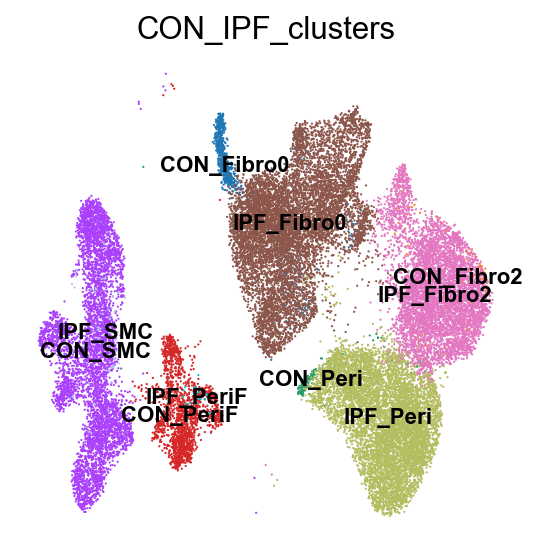

In [64]:
sc.pl.umap(adata, color= 'CONIPF_clusters', legend_loc= 'on data', legend_fontsize= 10, title= "CON_IPF_clusters", frameon= False)

In [68]:
#Identify DEGs in a cell type across conditions
sc.tl.rank_genes_groups(adata, 'CONIPF_clusters', groups= ['IPF_Peri'], reference= 'CON_Peri', method= 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:23)


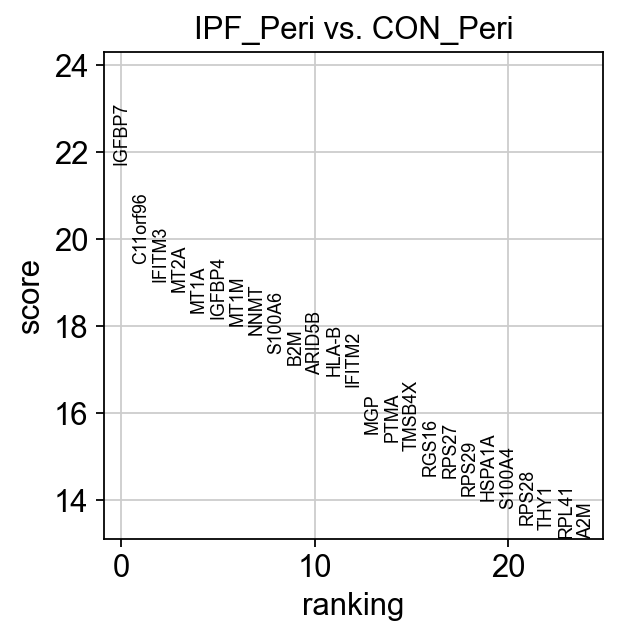

In [69]:
sc.pl.rank_genes_groups(adata, groups=["IPF_Peri"], n_genes= 25)

In [70]:
adata

AnnData object with n_obs × n_vars = 30651 × 22193
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'CONIPF_clusters'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors', 'CONIPF_clusters_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [72]:
result= adata.uns['rank_genes_groups']
groups= result['names'].dtype.names
df= pd.DataFrame(
    {group + '_' + key[:15]: result[key][group] 
    for group in groups for key in ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

In [73]:
df.to_csv("filtered_gene_bc_matrices/Peri_DEGs.csv")

In [74]:
result

{'params': {'groupby': 'CONIPF_clusters',
  'reference': 'CON_Peri',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('IGFBP7',), ('C11orf96',), ('IFITM3',), ..., ('SFTPC',),
            ('RGN',), ('EZR',)],
           dtype=[('IPF_Peri', 'O')]),
 'scores': rec.array([( 21.722734,), ( 19.42825 ,), ( 19.017136,), ...,
            (-16.439318,), (-16.785334,), (-17.375967,)],
           dtype=[('IPF_Peri', '<f4')]),
 'pvals': rec.array([(1.25108266e-104,), (4.45284406e-084,), (1.23023869e-080,),
            ..., (1.00037318e-060,), (3.12465325e-063,),
            (1.25474001e-067,)],
           dtype=[('IPF_Peri', '<f8')]),
 'pvals_adj': rec.array([(2.77652776e-100,), (4.94109841e-080,), (9.10089572e-077,),
            ..., (1.38758012e-057,), (4.95324497e-060,),
            (3.04097998e-064,)],
           dtype=[('IPF_Peri', '<f8')]),
 'logfoldchanges': rec.array([( 1.8677001,), (       nan,), (       nan,), ...,
